In [0]:
import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.layers import concatenate,Dropout,Flatten

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)


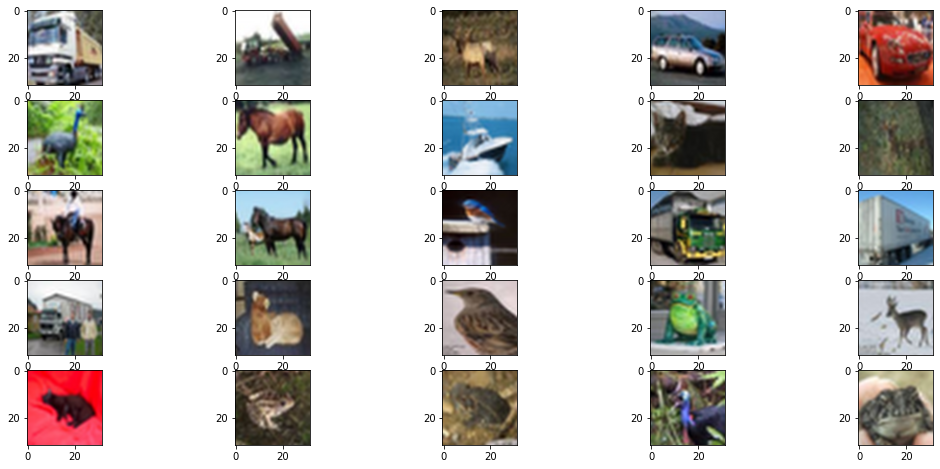

In [62]:
fig = plt.figure(figsize=(18, 8))
columns = 5
rows = 5
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i], interpolation='lanczos')

In [0]:
def alexnet(img_input,classes=10):
    xnet = Conv2D(96,(11,11),strides=(4,4),padding='same',
               activation='relu',kernel_initializer='uniform')(img_input)
    xnet = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(xnet)
    
    xnet = Conv2D(256,(5,5),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(xnet)
    xnet = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(xnet)
    
    xnet = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(xnet) 
    
    xnet = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(xnet) 
    
    xnet = Conv2D(256,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(xnet)
    xnet = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(xnet)
    xnet = Flatten()(xnet)
    xnet = Dense(4096,activation='relu')(xnet)
    xnet = Dropout(0.25)(xnet)
    xnet = Dense(4096,activation='relu')(xnet)
    xnet = Dropout(0.25)(xnet)
    out_model = Dense(classes, activation='softmax')(xnet)
    return out_model

In [88]:
img_input=Input(shape=(32,32,3))
output = alexnet(img_input)
model=Model(img_input,output)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 2, 2, 384)         1327

In [69]:
sgd = optimizers.SGD(lr=.01, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
epochs = 50

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.115,
                             height_shift_range=0.115,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=(x_test, y_test))


Epoch 1/50
782/782 [==============================] - 24s 31ms/step - loss: 1.7050 - acc: 0.3672 - val_loss: 1.4271 - val_acc: 0.4745

Epoch 00001: val_acc improved from -inf to 0.47450, saving model to weights.best.hdf5
Epoch 2/50
782/782 [==============================] - 24s 31ms/step - loss: 1.4002 - acc: 0.4963 - val_loss: 1.2964 - val_acc: 0.5378

Epoch 00002: val_acc improved from 0.47450 to 0.53780, saving model to weights.best.hdf5
Epoch 3/50
782/782 [==============================] - 23s 29ms/step - loss: 1.2742 - acc: 0.5440 - val_loss: 1.1533 - val_acc: 0.5983

Epoch 00003: val_acc improved from 0.53780 to 0.59830, saving model to weights.best.hdf5
Epoch 4/50
782/782 [==============================] - 23s 29ms/step - loss: 1.1875 - acc: 0.5768 - val_loss: 1.1104 - val_acc: 0.5992

Epoch 00004: val_acc improved from 0.59830 to 0.59920, saving model to weights.best.hdf5
Epoch 5/50
782/782 [==============================] - 24s 30ms/step - loss: 1.1259 - acc: 0.6011 - val_loss

In [72]:
model.history

Text(0, 0.5, 'acc')

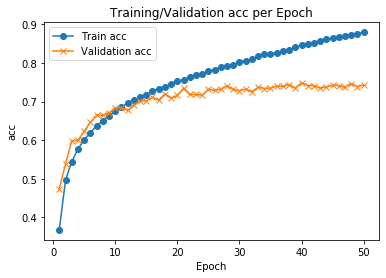

In [73]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()

ax.plot([None] + model.history.history['acc'], 'o-')
ax.plot([None] + model.history.history['val_acc'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'acc')

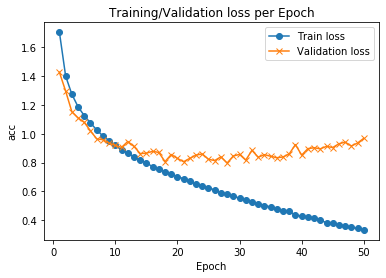

In [74]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + model.history.history['loss'], 'o-')
ax.plot([None] + model.history.history['val_loss'], 'x-')
ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

In [0]:
predictions = model.predict(x_test)

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np



In [79]:
confusion_matrix(y_test, np.argmax(predictions,axis=1))

ValueError: ignored

In [80]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [81]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

8

In [0]:
cm = confusion_matrix(rounded_labels, np.argmax(predictions,axis=1))

In [83]:
cm

array([[843,  19,  21,   8,  14,   5,  10,  11,  48,  21],
       [ 19, 878,   2,   3,   3,   5,   6,   4,  21,  59],
       [ 79,  11, 618,  41,  77,  43,  67,  36,  15,  13],
       [ 29,  29,  62, 499,  54, 168,  73,  42,  17,  27],
       [ 23,   6,  61,  47, 686,  34,  43,  82,  15,   3],
       [ 14,  14,  29, 127,  50, 632,  45,  65,  10,  14],
       [  8,  10,  47,  41,  33,  23, 815,   7,   5,  11],
       [ 17,   5,  14,  24,  35,  60,   9, 817,   7,  12],
       [ 53,  45,   6,   9,   2,   3,   2,   2, 860,  18],
       [ 38, 117,   4,   6,   3,   4,   7,   6,  34, 781]])

In [0]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()

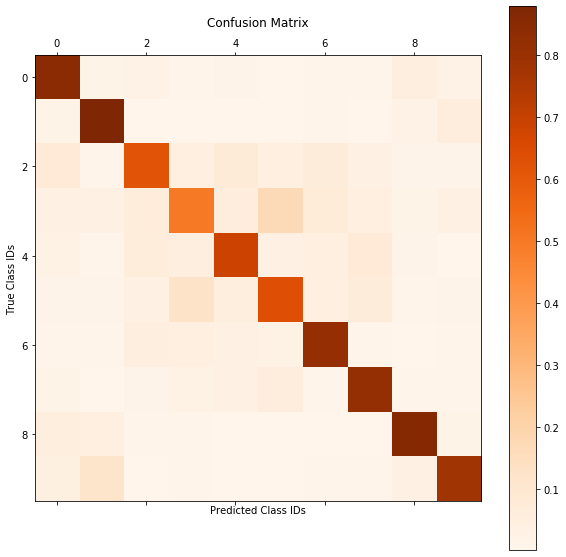

In [85]:
plot_confusion_matrix(cm)

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np

